# Common methods to perform Time Series forecasting

This notebook is based on [this post](https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/), which introduces all the techniques covered in the [README.md](https://github.com/YuZhangIsCoding/StatsBasics/blob/master/TimeSeriesAnalysis/README.md), including:

1. Simple Average
1. Moving Average
1. Exponential Smoothing
    1. Single Exponential Smoothing
    1. Double Exponential Smoothing (Holt's method)
    1. Triple Exponential Smoothing (Holt-Winters method)
1. Autoregressive Integrated Moving Avearge

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
pd.options.display.max_rows = 20

In [2]:
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from statsmodels.tsa.stattools import acf, pacf

In [3]:
plt.rcParams['figure.figsize'] = 8, 3
plt.rcParams['figure.dpi'] = 300

Load data for bitcoin price

In [4]:
dateparser = lambda dates: pd.datetime.strptime(dates, '%d-%m-%Y %H:%M')
bt = pd.read_csv('data/Bitcoin_train.csv', parse_dates=['Datetime'], 
                 date_parser = dateparser, index_col = 'Datetime')

Aggreating the dataset at daily level, and subsetting train and test sets

In [5]:
bt = bt.resample('D').mean()
ntot = sum(bt.index < '2014-06')
train = bt[:ntot]
test = bt[ntot:]

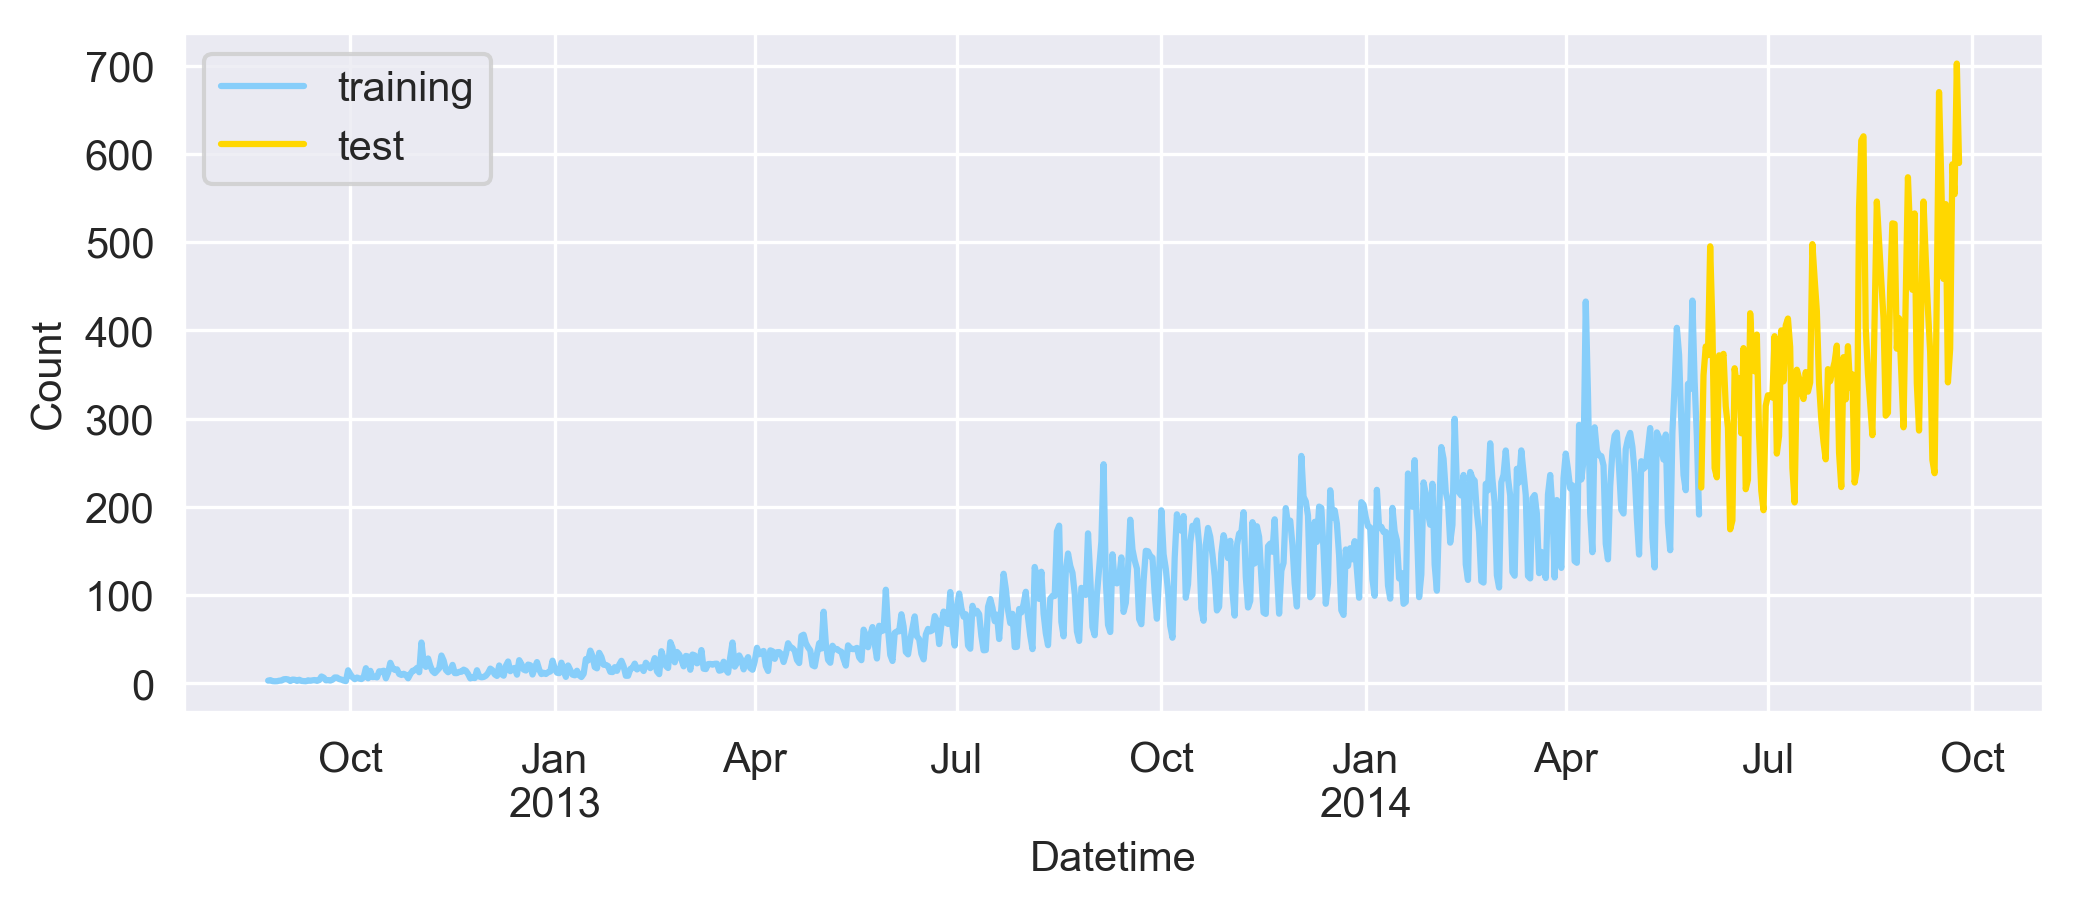

In [6]:
train['Count'].plot(label='training', color = 'lightskyblue')
test['Count'].plot(label='test', color = 'gold')
plt.ylabel('Count')
plt.legend();

## Simple Average

$\hat{y}_{t+1}=\frac{1}{t}\sum_{i=1}^ty_i$

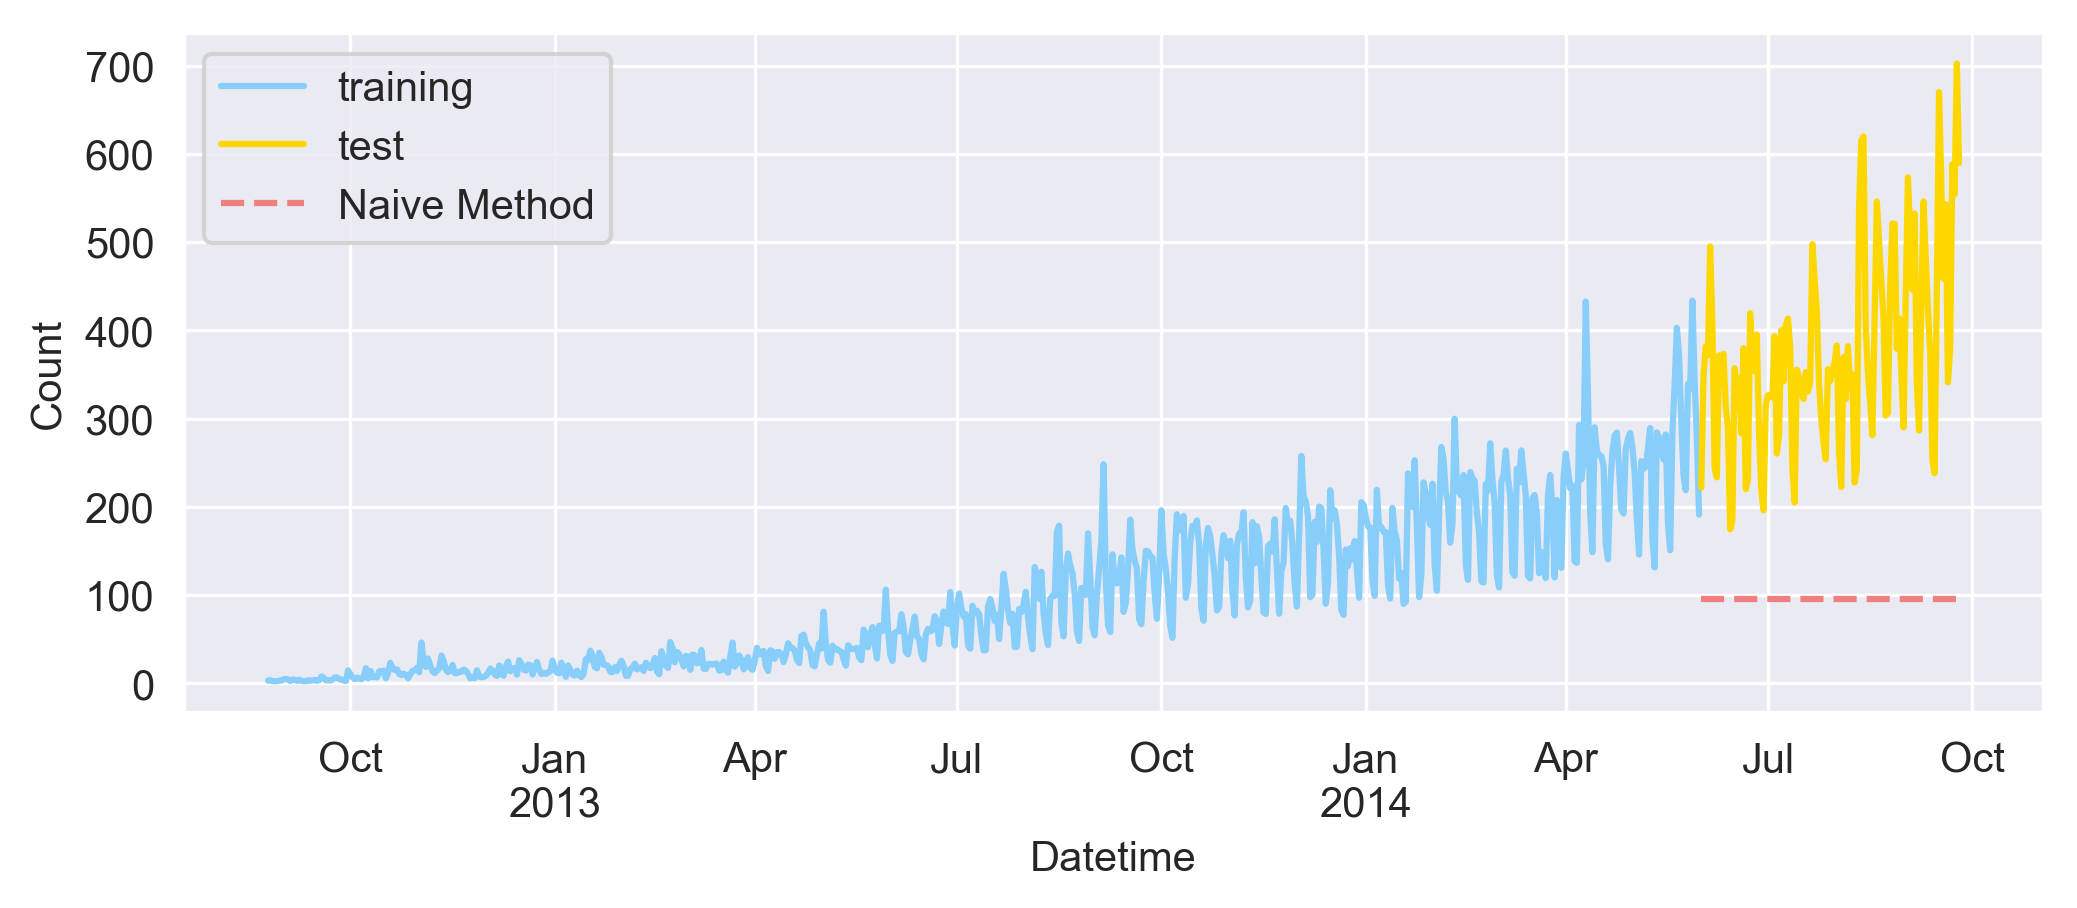

In [7]:
result_simple = pd.Series(train['Count'].mean(), index = test.index)
train['Count'].plot(label='training', color = 'lightskyblue')
test['Count'].plot(label='test', color = 'gold')
result_simple.plot(ls = '--', label='Naive Method', color='lightcoral')
plt.ylabel('Count')
plt.legend();

In [8]:
RMSE = {}
RMSE['simple'] = np.sqrt(mean_squared_error(test['Count'], result_simple))
print(RMSE['simple'])

299.69811486958645


## Moving Average

In [9]:
ma_fitted = train['Count'].rolling(60).mean()
ma_results = pd.Series(ma_fitted[-1], index = test.index)

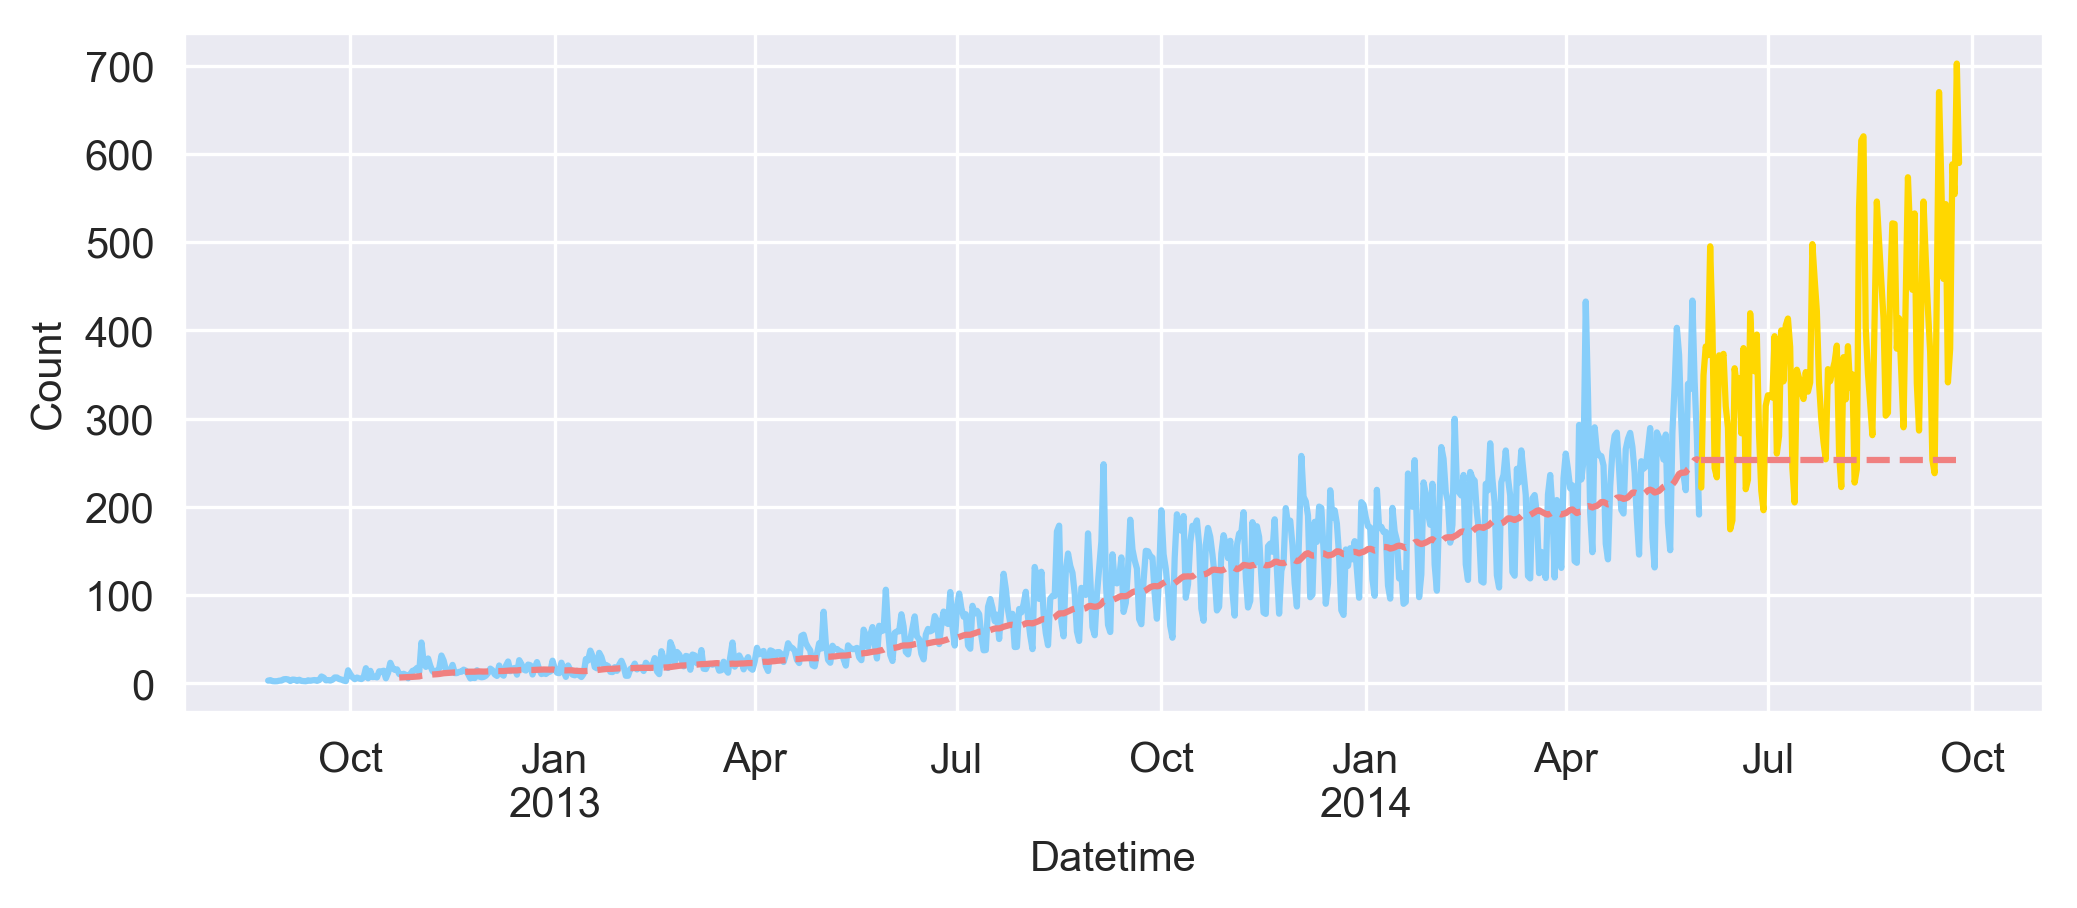

In [10]:
train['Count'].plot(label='training', color = 'lightskyblue')
test['Count'].plot(label='test', color = 'gold')
ma_fitted.plot(ls = '--', color = 'lightcoral', label = 'Moving Average')
ma_results.plot(ls = '--', color = 'lightcoral')
plt.ylabel('Count');

In [11]:
RMSE['MA'] = np.sqrt(mean_squared_error(test['Count'], ma_results))

In [12]:
print(RMSE['MA'])

163.7201366726314


### Exponentially weightly average

In [13]:
ewma_fitted = train['Count'].ewm(halflife = 30).mean()
ewma_results = pd.Series(ewma_fitted[-1], index = test.index)

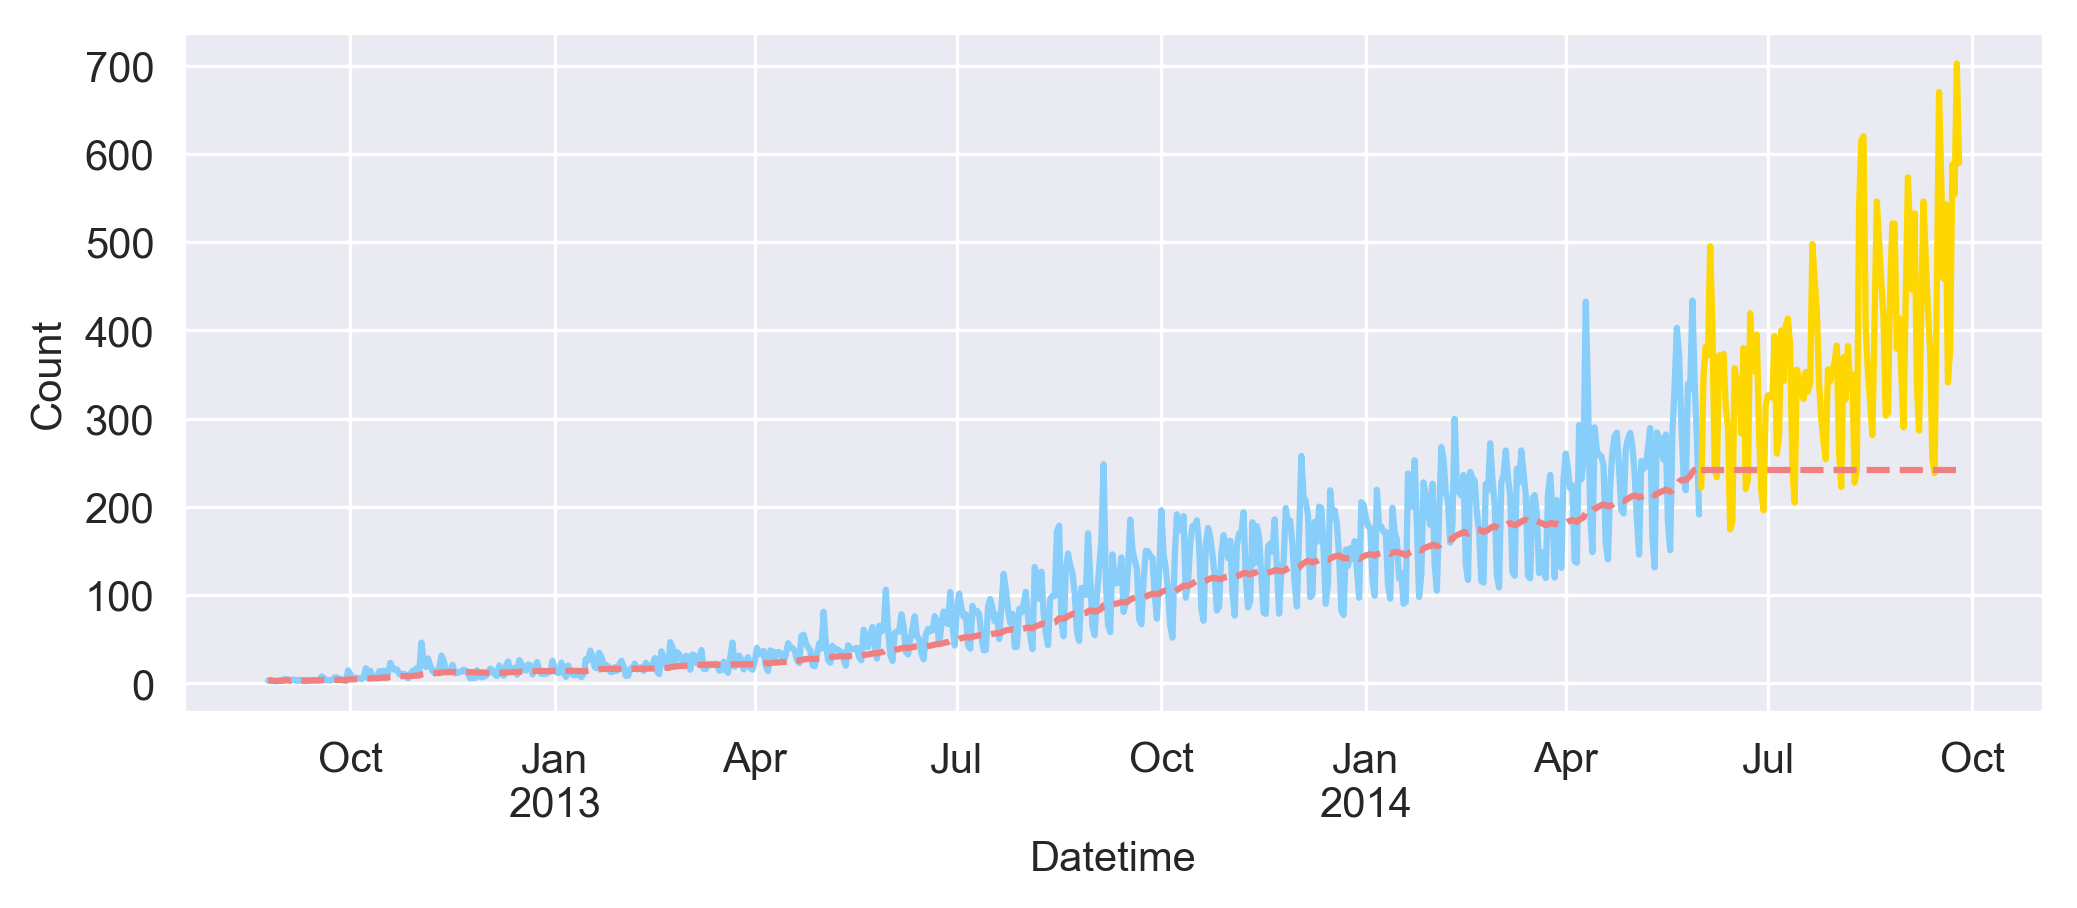

In [14]:
train['Count'].plot(label='training', color = 'lightskyblue')
test['Count'].plot(label='test', color = 'gold')
ewma_fitted.plot(ls = '--', color = 'lightcoral', label = 'Moving Average')
ewma_results.plot(ls = '--', color = 'lightcoral')
plt.ylabel('Count');

In [15]:
RMSE['EWMA'] = np.sqrt(mean_squared_error(test['Count'], ewma_results))
print(RMSE['EWMA'])

172.19688548257133


## Exponential Smoothing

### Simple Exponential Smoothing

In [16]:
ses = SimpleExpSmoothing(train['Count']).fit(smoothing_level=0.6,optimized=False)
ses_results = ses.forecast(len(test))

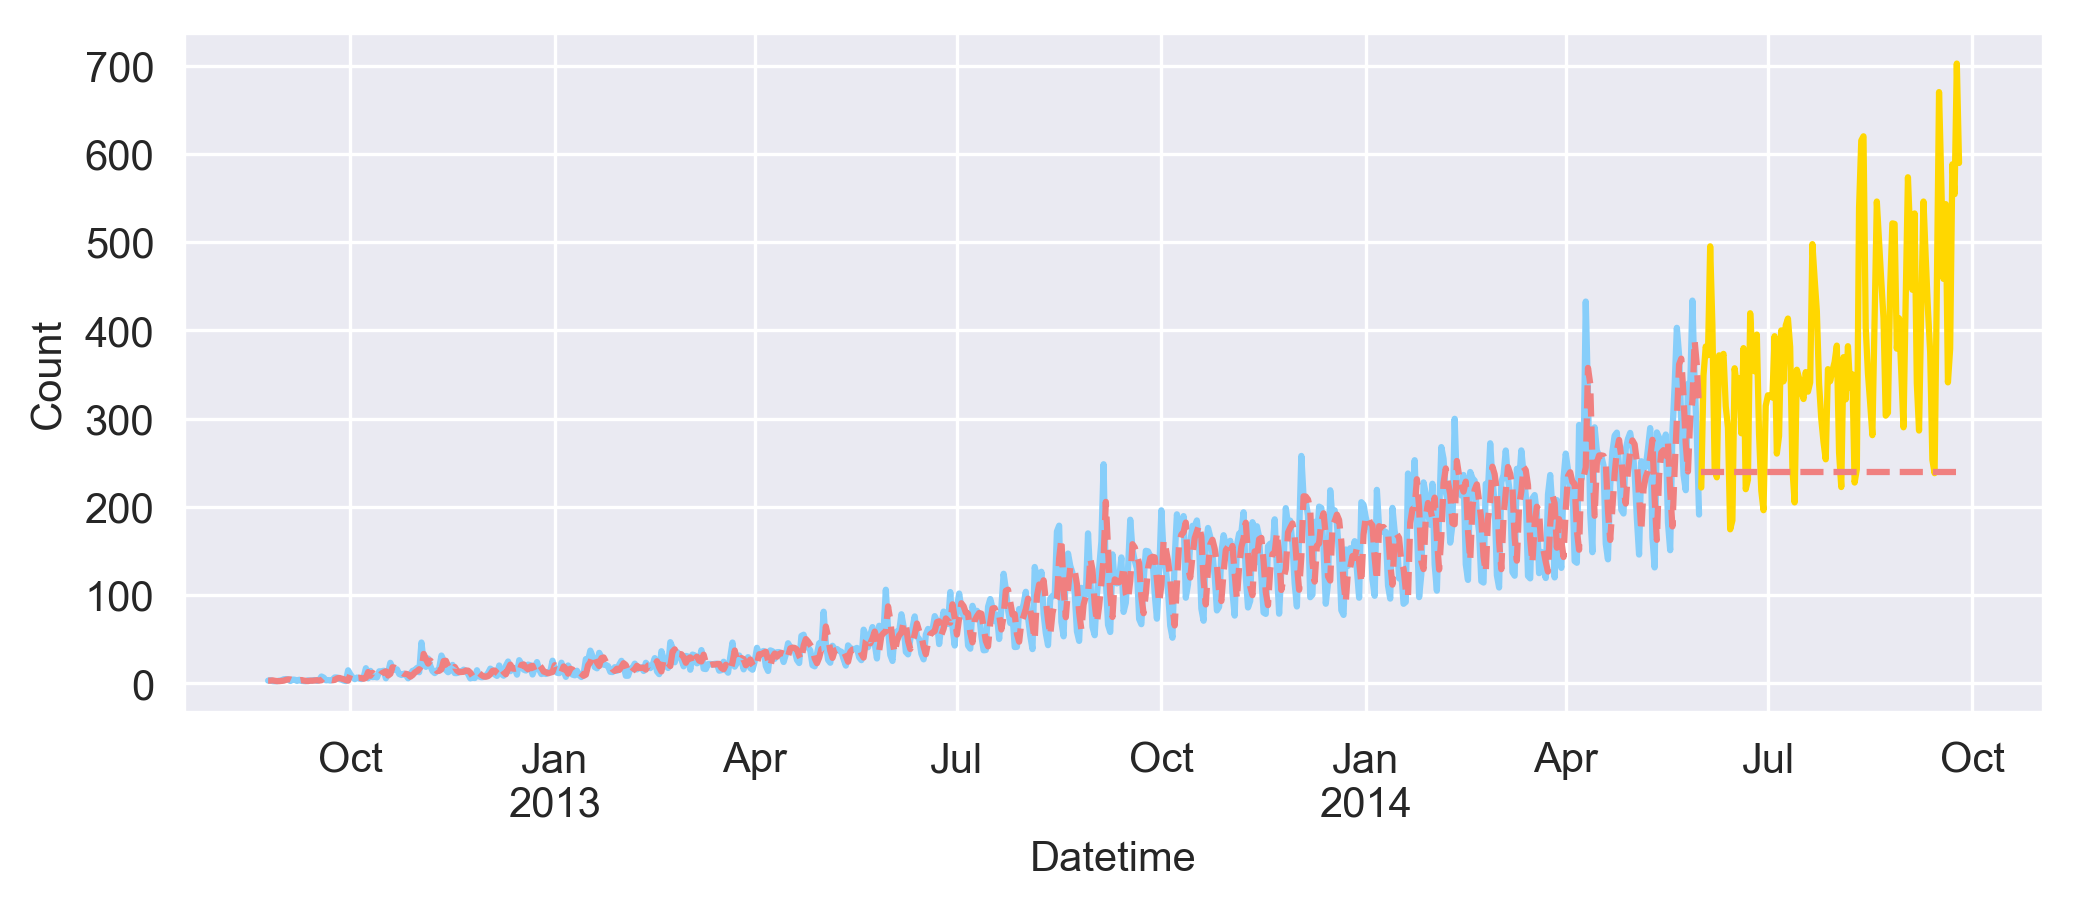

In [17]:
train['Count'].plot(label='training', color = 'lightskyblue')
test['Count'].plot(label='test', color = 'gold')
ses.fittedvalues.plot(ls = '--', color = 'lightcoral', label = 'Simple Exp')
ses_results.plot(ls = '--', color = 'lightcoral')
plt.ylabel('Count');

In [18]:
RMSE['ses'] = np.sqrt(mean_squared_error(test['Count'], ses_results))
print(RMSE['ses'])

173.78067172240145


### Double Exponential Smoothing (Holt's linear method)

In [19]:
decomposed = sm.tsa.seasonal_decompose(train['Count'])

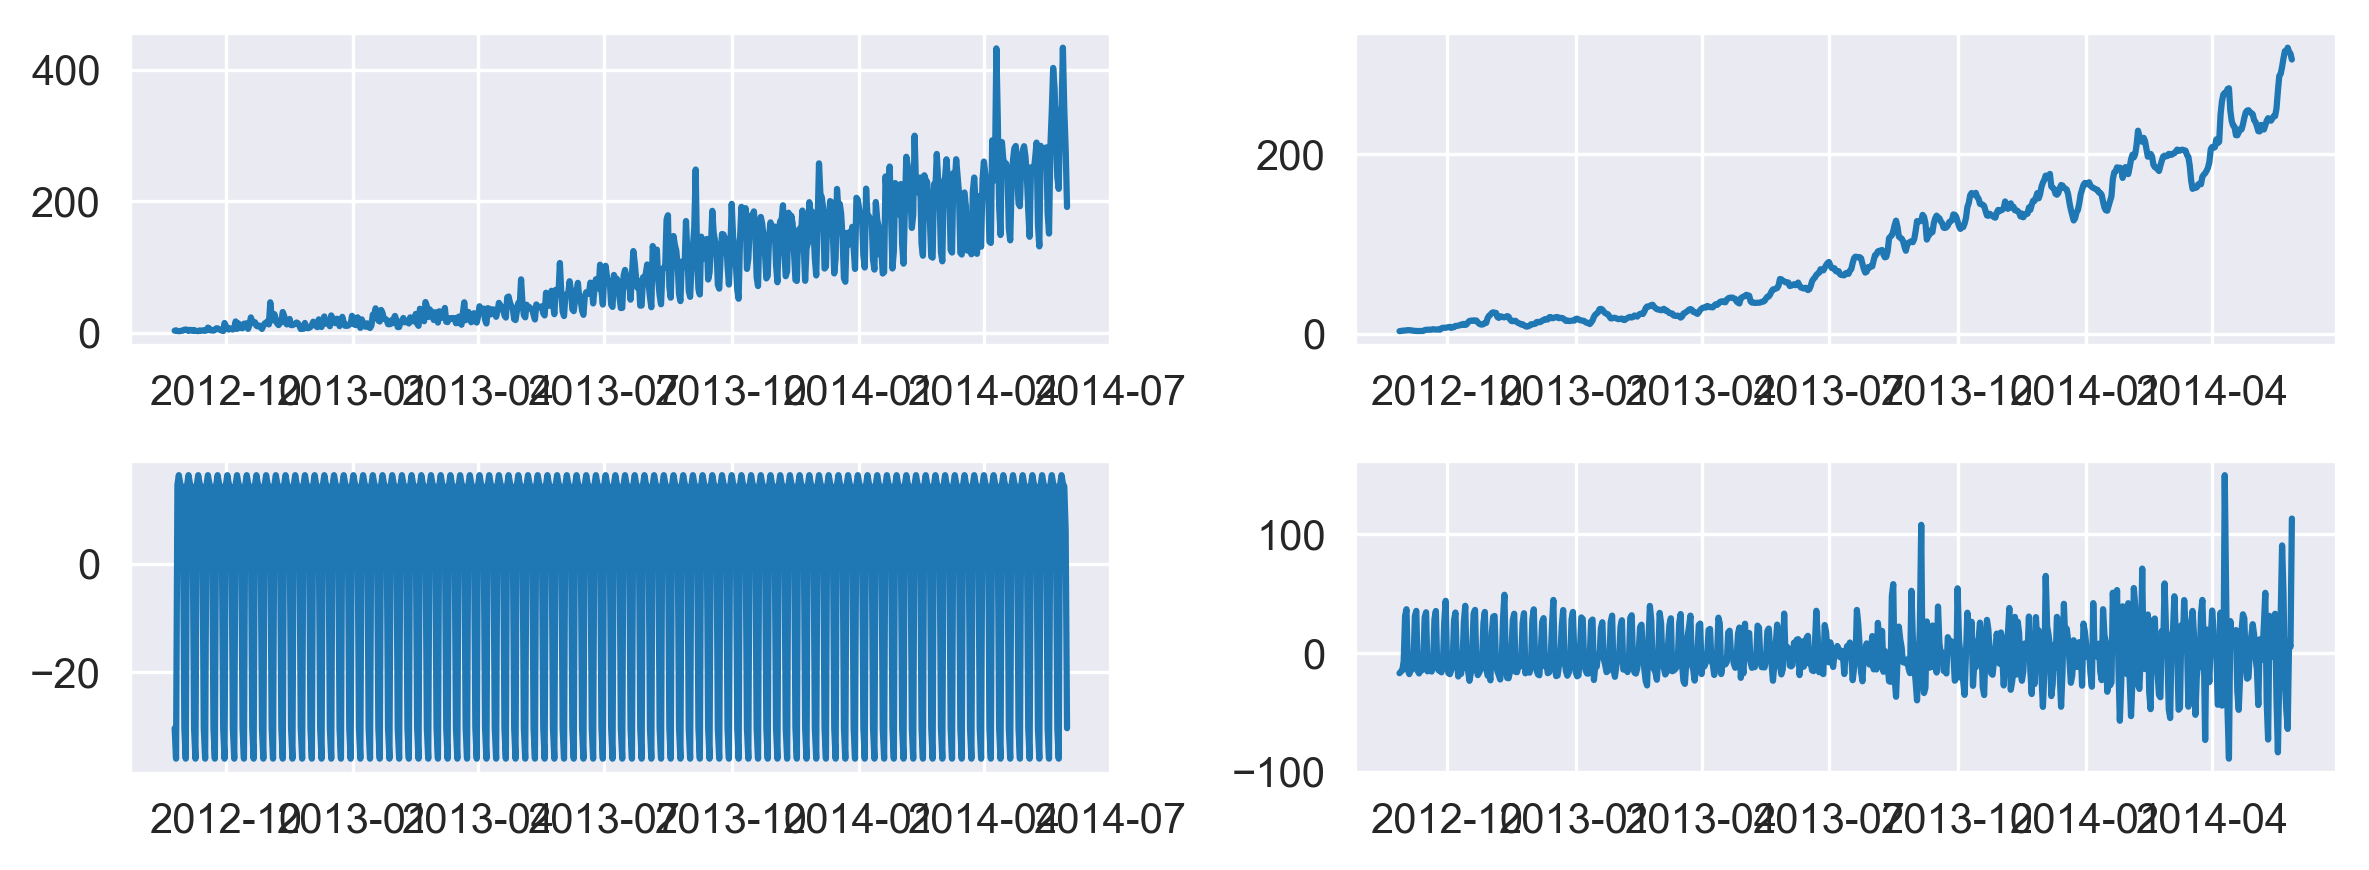

In [20]:
fig, axes = plt.subplots(2, 2, figsize = (8, 3))
axes[0][0].plot(decomposed.observed)
axes[0][1].plot(decomposed.trend)
axes[1][0].plot(decomposed.seasonal)
axes[1][1].plot(decomposed.resid)
plt.tight_layout();

#### Additive

In [21]:
des = Holt(train['Count']).fit(smoothing_level=0.3, smoothing_slope=0.1, optimized=False)
des_results = des.forecast(len(test))

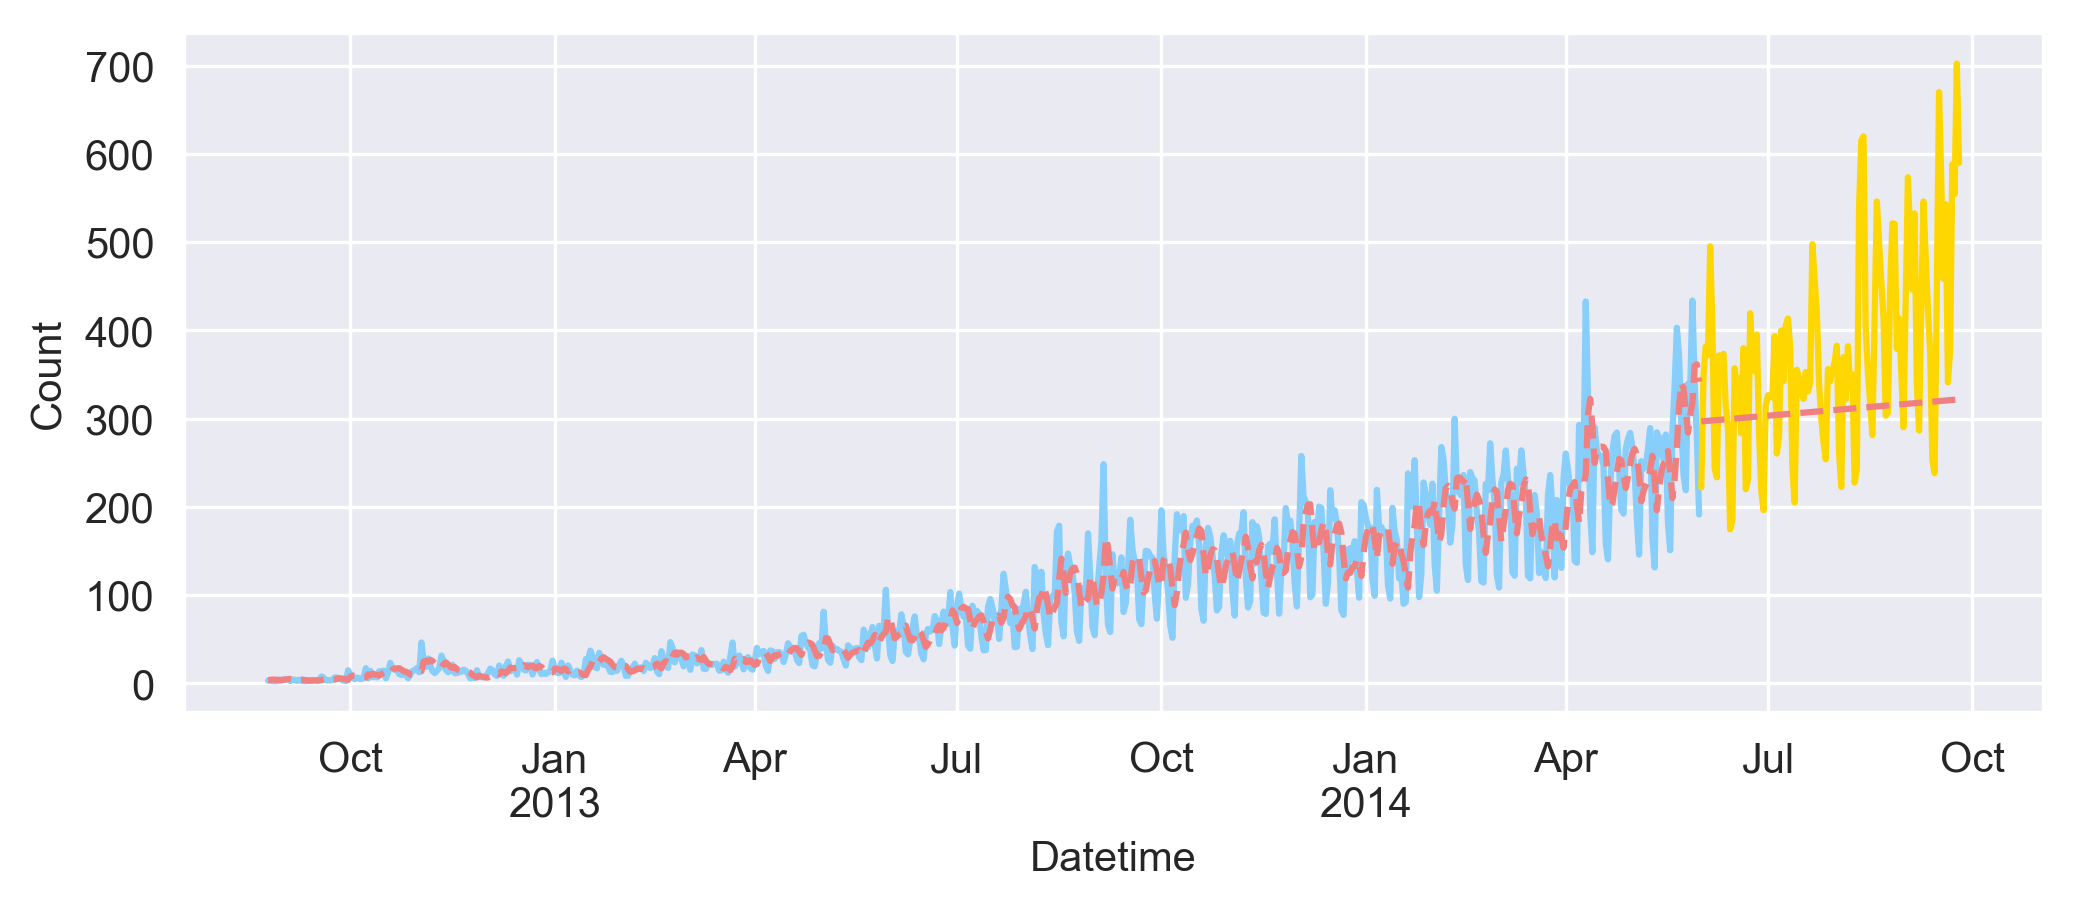

In [22]:
train['Count'].plot(label='training', color = 'lightskyblue')
test['Count'].plot(label='test', color = 'gold')
des.fittedvalues.plot(ls = '--', color = 'lightcoral', label = 'Double Exp Additive')
des_results.plot(ls = '--', color = 'lightcoral')
plt.ylabel('Count');

In [23]:
RMSE['des_add'] = np.sqrt(mean_squared_error(test['Count'], des_results))
print(RMSE['des_add'])

124.04949038445164


#### Multiplicative

In [24]:
des_mul = Holt(train['Count'], exponential=True).fit()
des_mul_results = des_mul.forecast(len(test))

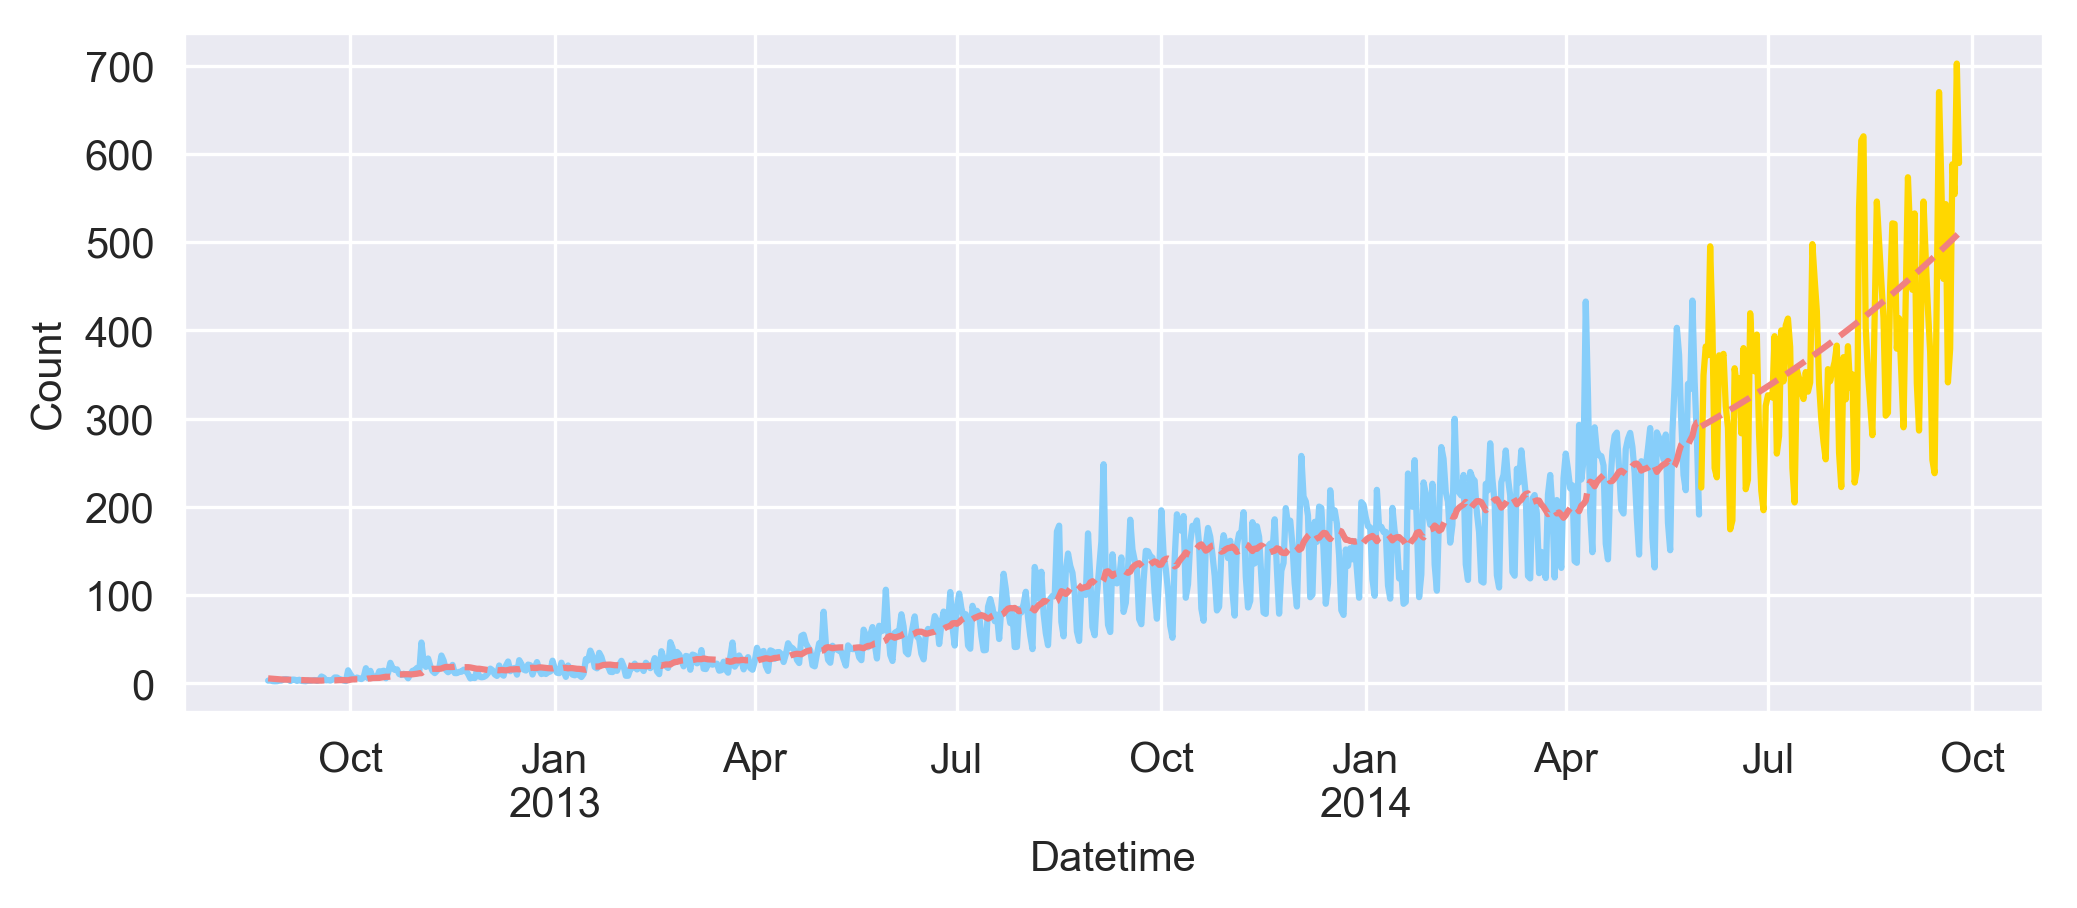

In [25]:
train['Count'].plot(label='training', color = 'lightskyblue')
test['Count'].plot(label='test', color = 'gold')
des_mul.fittedvalues.plot(ls = '--', color = 'lightcoral', label = 'Double Exp Multiplicative')
des_mul_results.plot(ls = '--', color = 'lightcoral')
plt.ylabel('Count');

In [26]:
RMSE['des_mul'] = np.sqrt(mean_squared_error(test['Count'], des_mul_results))
print(RMSE['des_mul'])

94.37896391087666


### Triple Exponential Smoothing (Holt-Winters method)

<StemContainer object of 3 artists>

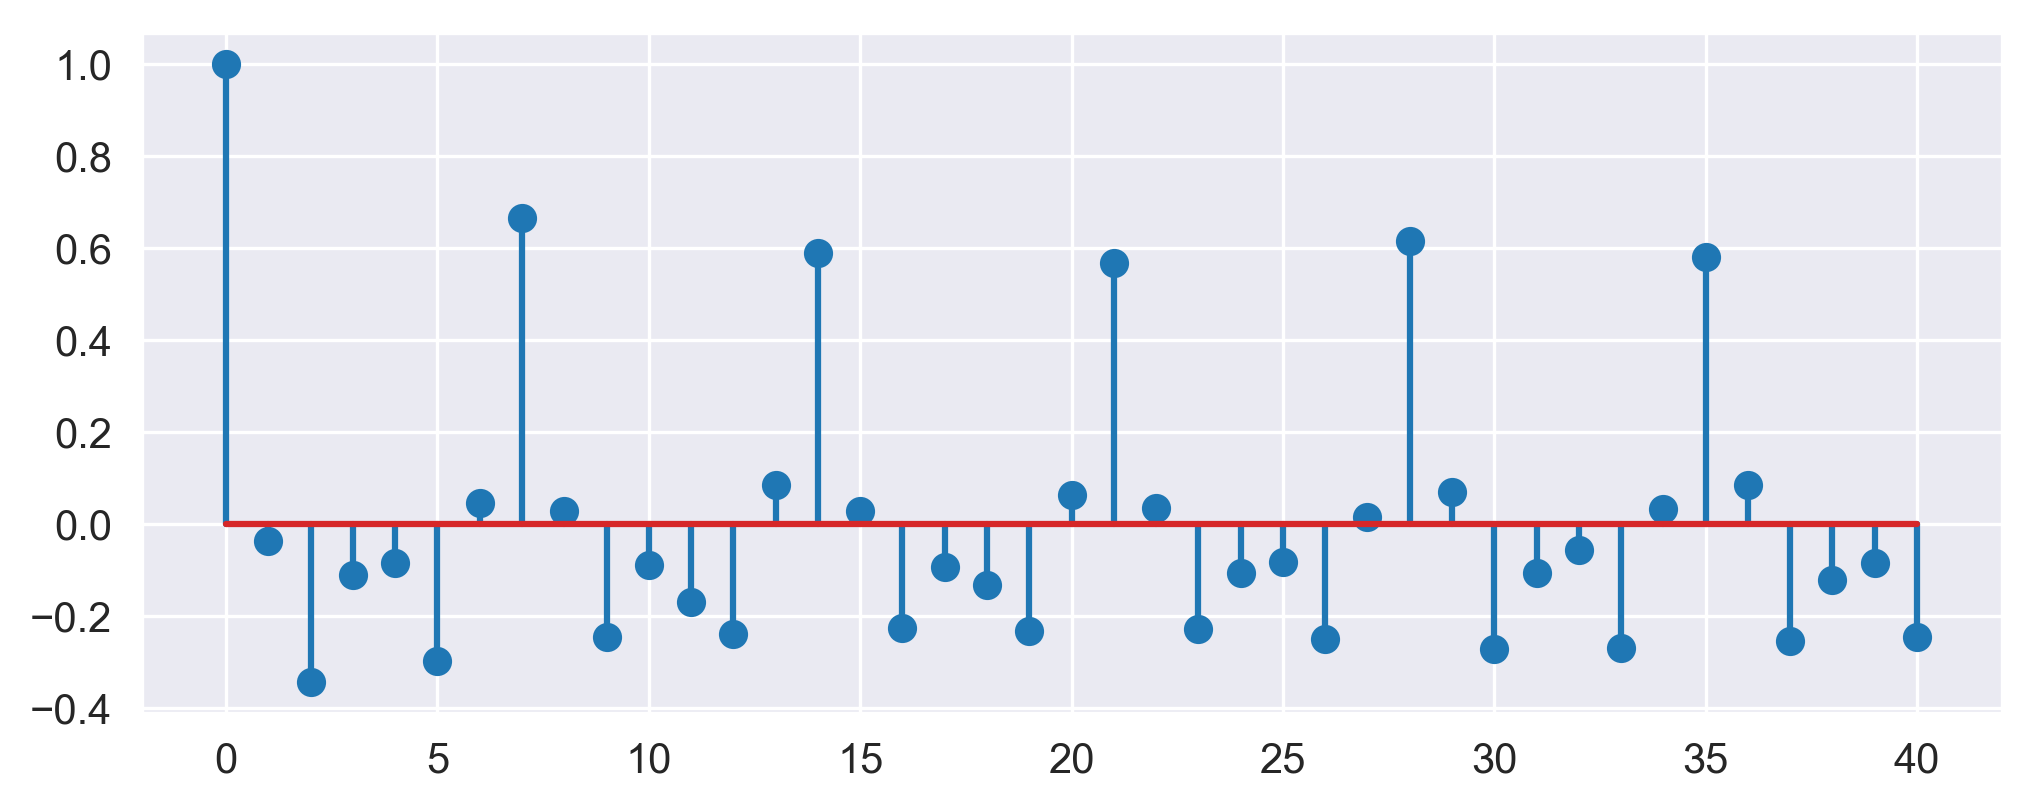

In [27]:
train_diff = train['Count']-train['Count'].shift()
plt.stem(acf(train_diff.dropna()))

The data seem to have a seasonality of 7 days

#### Additive trend, additive seasonality

In [28]:
tes_add_add = ExponentialSmoothing(train['Count'], seasonal_periods=7, 
                           trend='add', seasonal='add').fit(use_boxcox=True)
tes_add_add_results = tes_add_add.forecast(len(test))

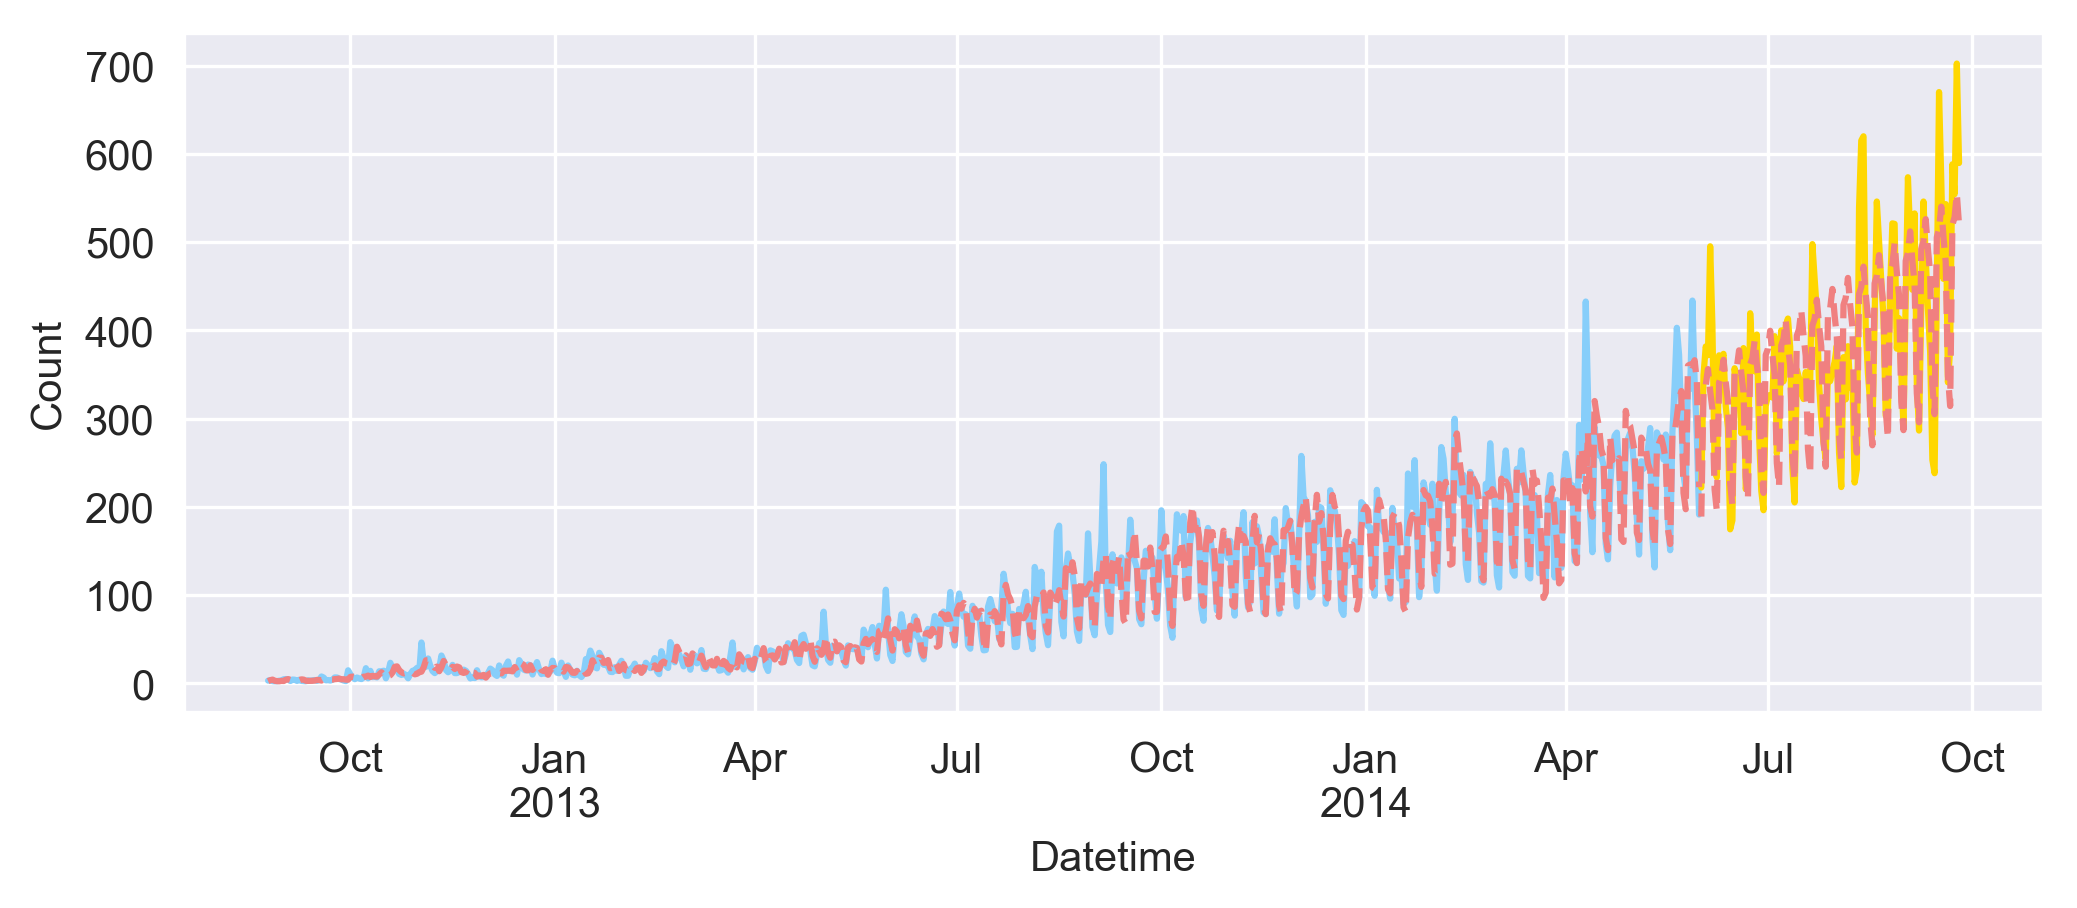

In [29]:
train['Count'].plot(label='training', color = 'lightskyblue')
test['Count'].plot(label='test', color = 'gold')
tes_add_add.fittedvalues.plot(ls = '--', color = 'lightcoral', 
                              label = 'Triple Exp Add-Add')
tes_add_add_results.plot(ls = '--', color = 'lightcoral')
plt.ylabel('Count');

In [30]:
RMSE['tes_add_add'] = np.sqrt(mean_squared_error(test['Count'], tes_add_add_results))
print(RMSE['tes_add_add'])

59.67683988643407


#### Additive trend, Multiplicative seasonality

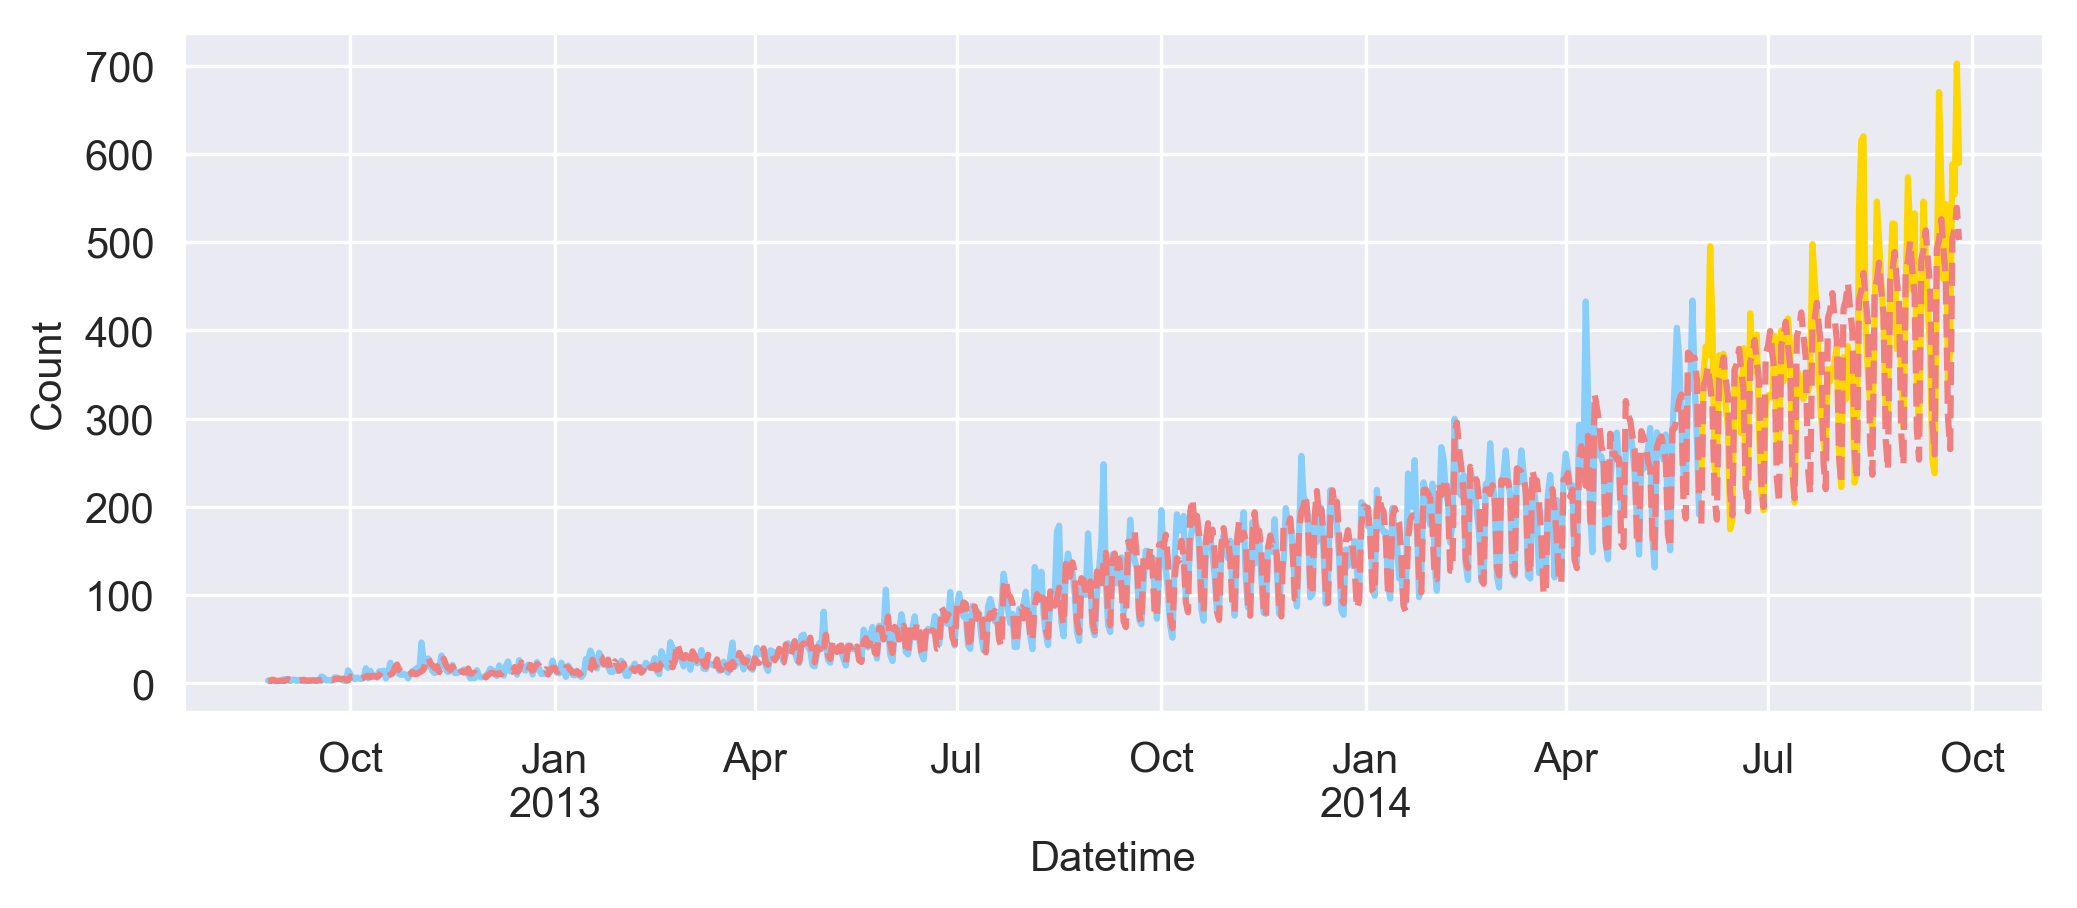

In [31]:
tes_add_mul = ExponentialSmoothing(train['Count'], seasonal_periods=7, 
                           trend='add', seasonal='mul').fit(use_boxcox=True)
tes_add_mul_results = tes_add_mul.forecast(len(test))
train['Count'].plot(label='training', color = 'lightskyblue')
test['Count'].plot(label='test', color = 'gold')
tes_add_mul.fittedvalues.plot(ls = '--', color = 'lightcoral', 
                              label = 'Triple Exp Add-Mul')
tes_add_mul_results.plot(ls = '--', color = 'lightcoral')
plt.ylabel('Count');

In [32]:
RMSE['tes_add_mul'] = np.sqrt(mean_squared_error(test['Count'], tes_add_mul_results))
print(RMSE['tes_add_mul'])

61.94150328619877


## ARIMA

In [33]:
train_log = np.log(train['Count'])

<StemContainer object of 3 artists>

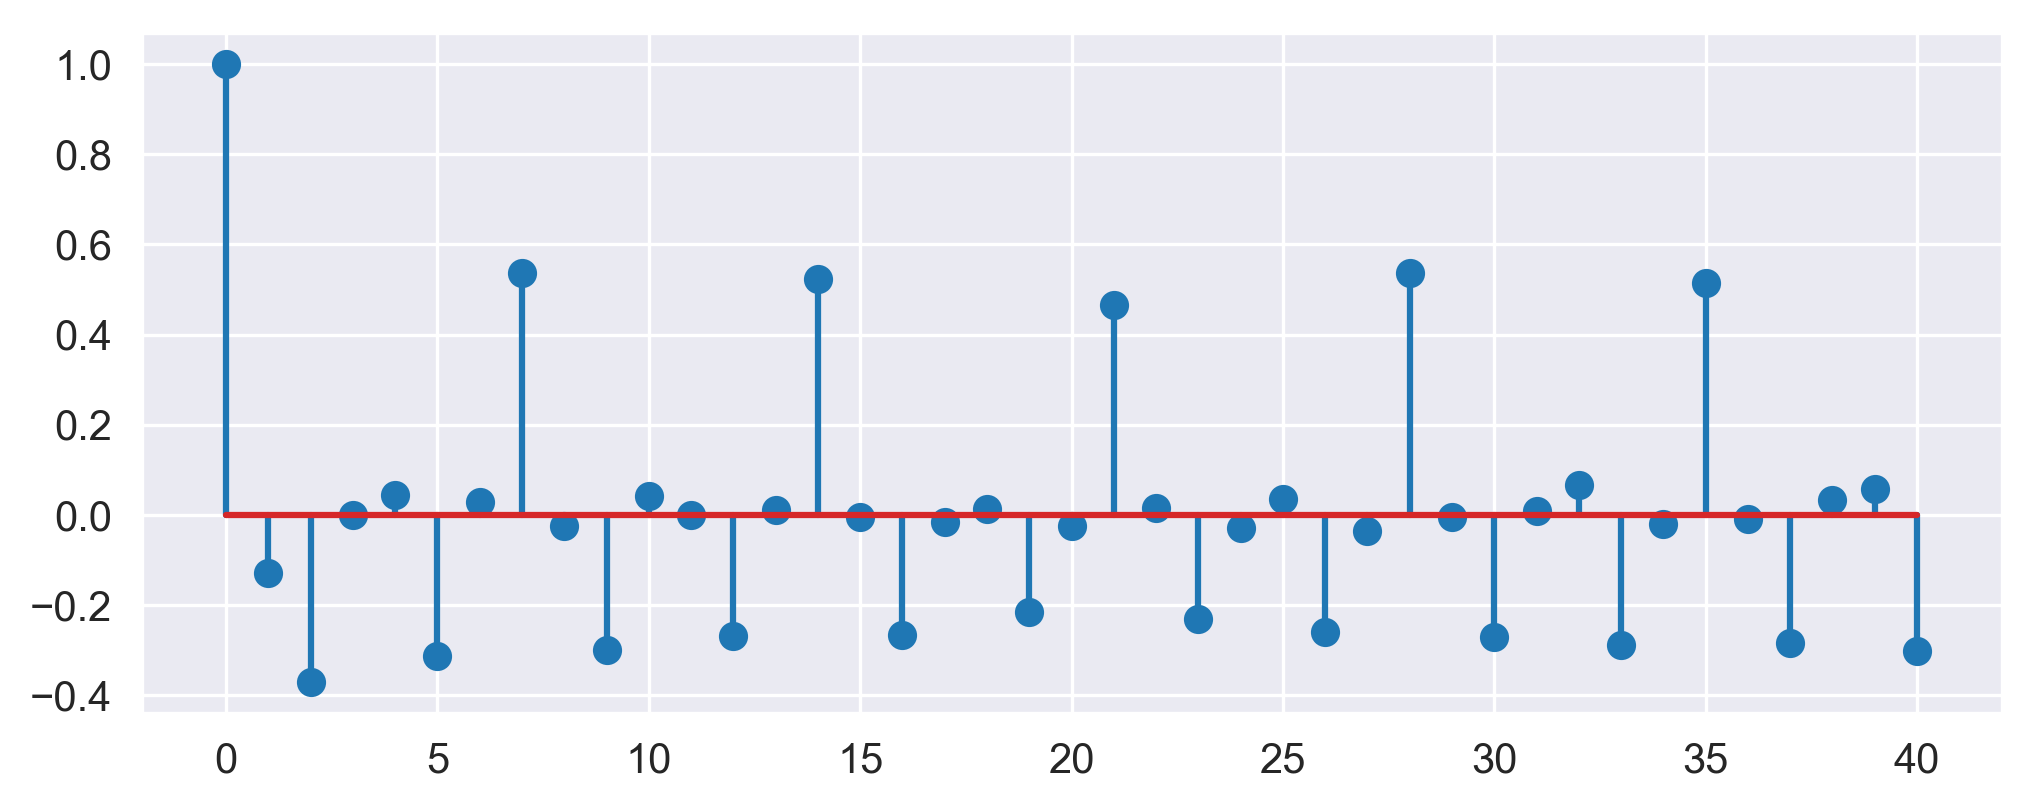

In [34]:
train_log_diff = (train_log-train_log.shift()).dropna()

plt.stem(acf(train_log_diff))

In [35]:
train_log_diff_sdiff = (train_log_diff-train_log_diff.shift(7)).dropna()

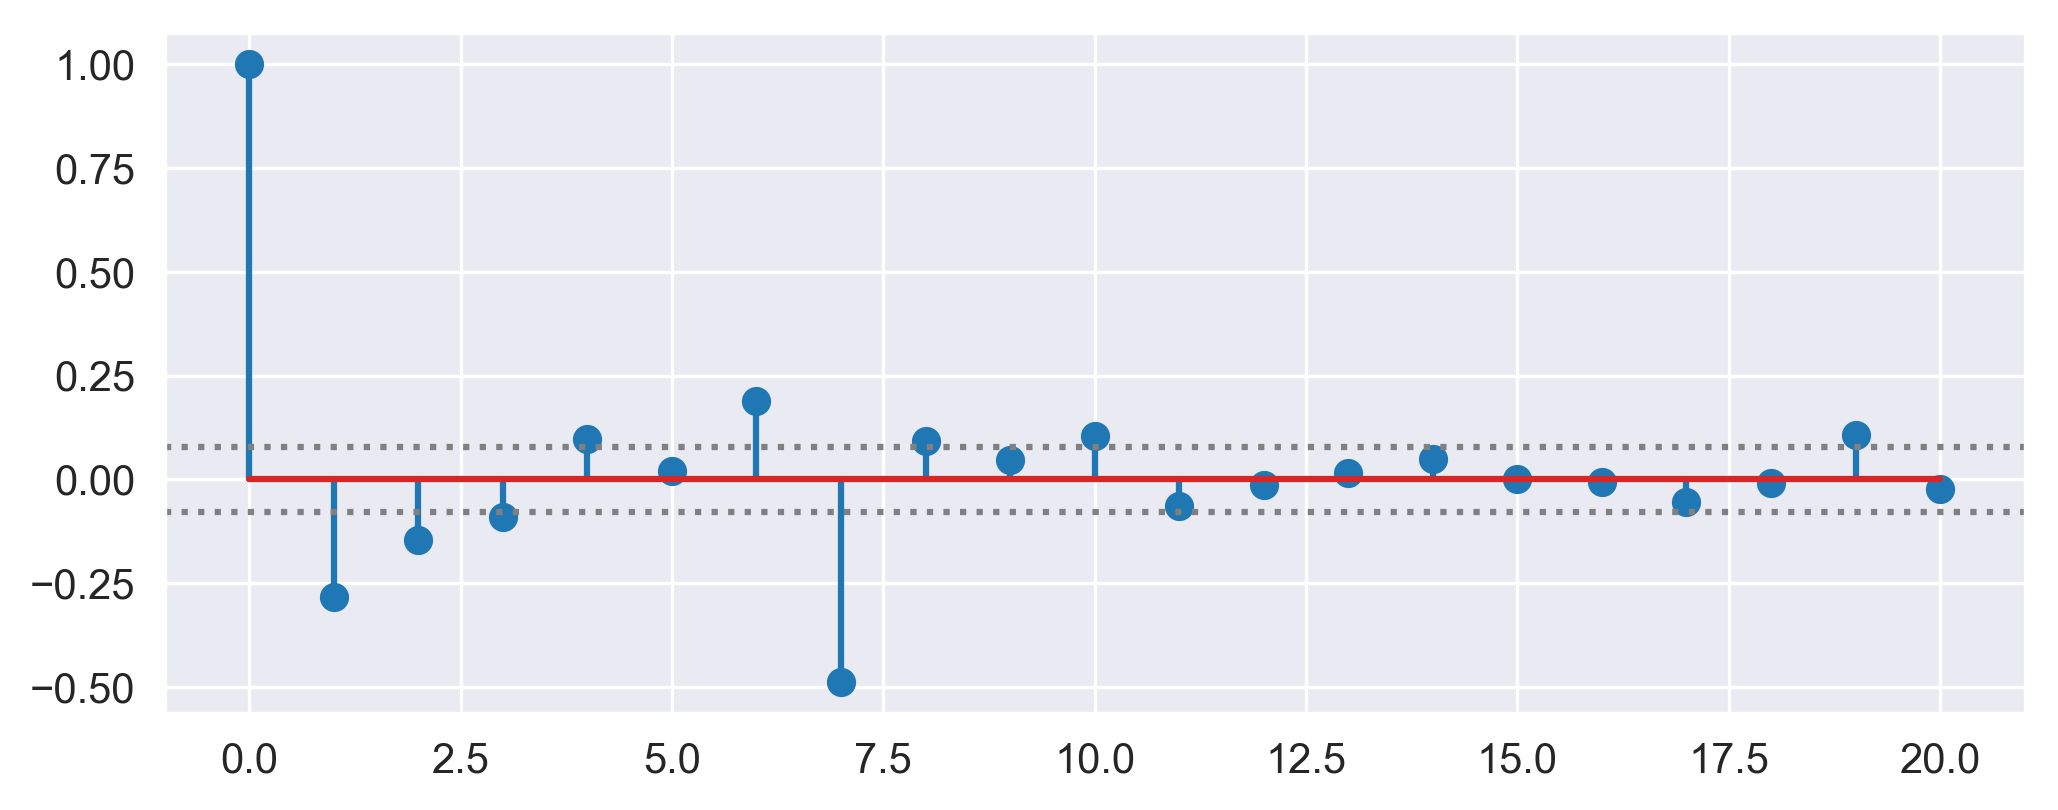

In [36]:
plt.stem(acf(train_log_diff_sdiff, nlags = 20))
plt.axhline(1.96/np.sqrt(len(train_log_diff_sdiff)), ls = ':', color = 'gray')
plt.axhline(-1.96/np.sqrt(len(train_log_diff_sdiff)), ls = ':', color = 'gray')

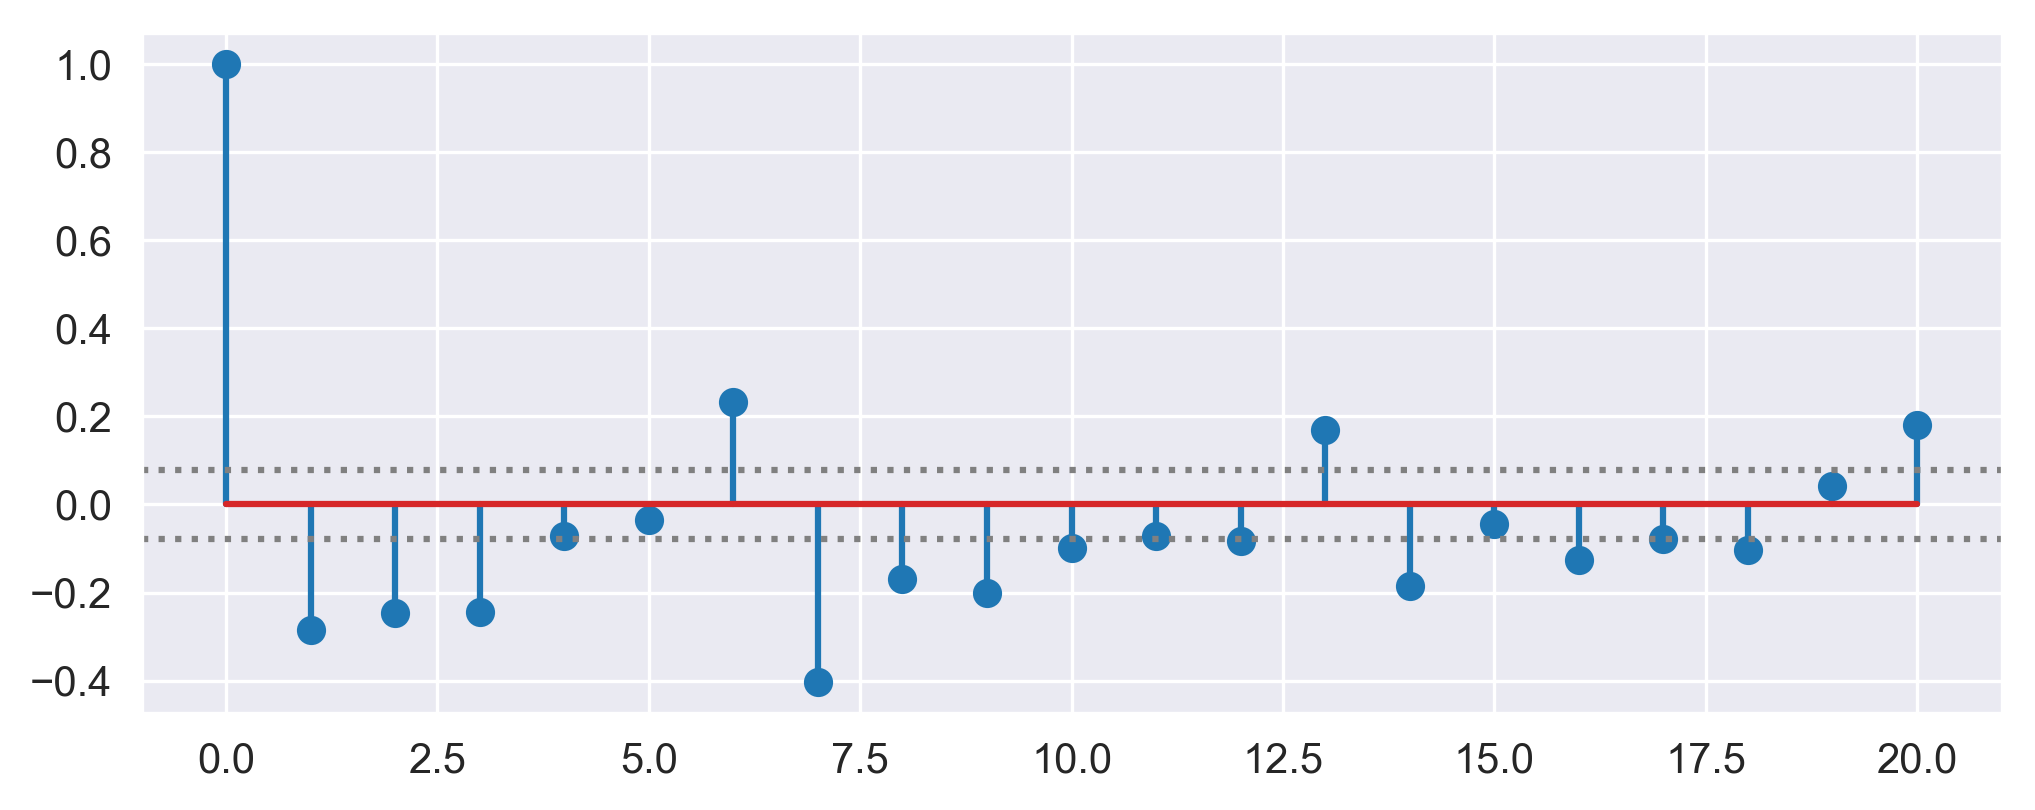

In [37]:
plt.stem(pacf(train_log_diff_sdiff, nlags = 20))
plt.axhline(1.96/np.sqrt(len(train_log_diff_sdiff)), ls = ':', color = 'gray')
plt.axhline(-1.96/np.sqrt(len(train_log_diff_sdiff)), ls = ':', color = 'gray')

/Users/yuzhang/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


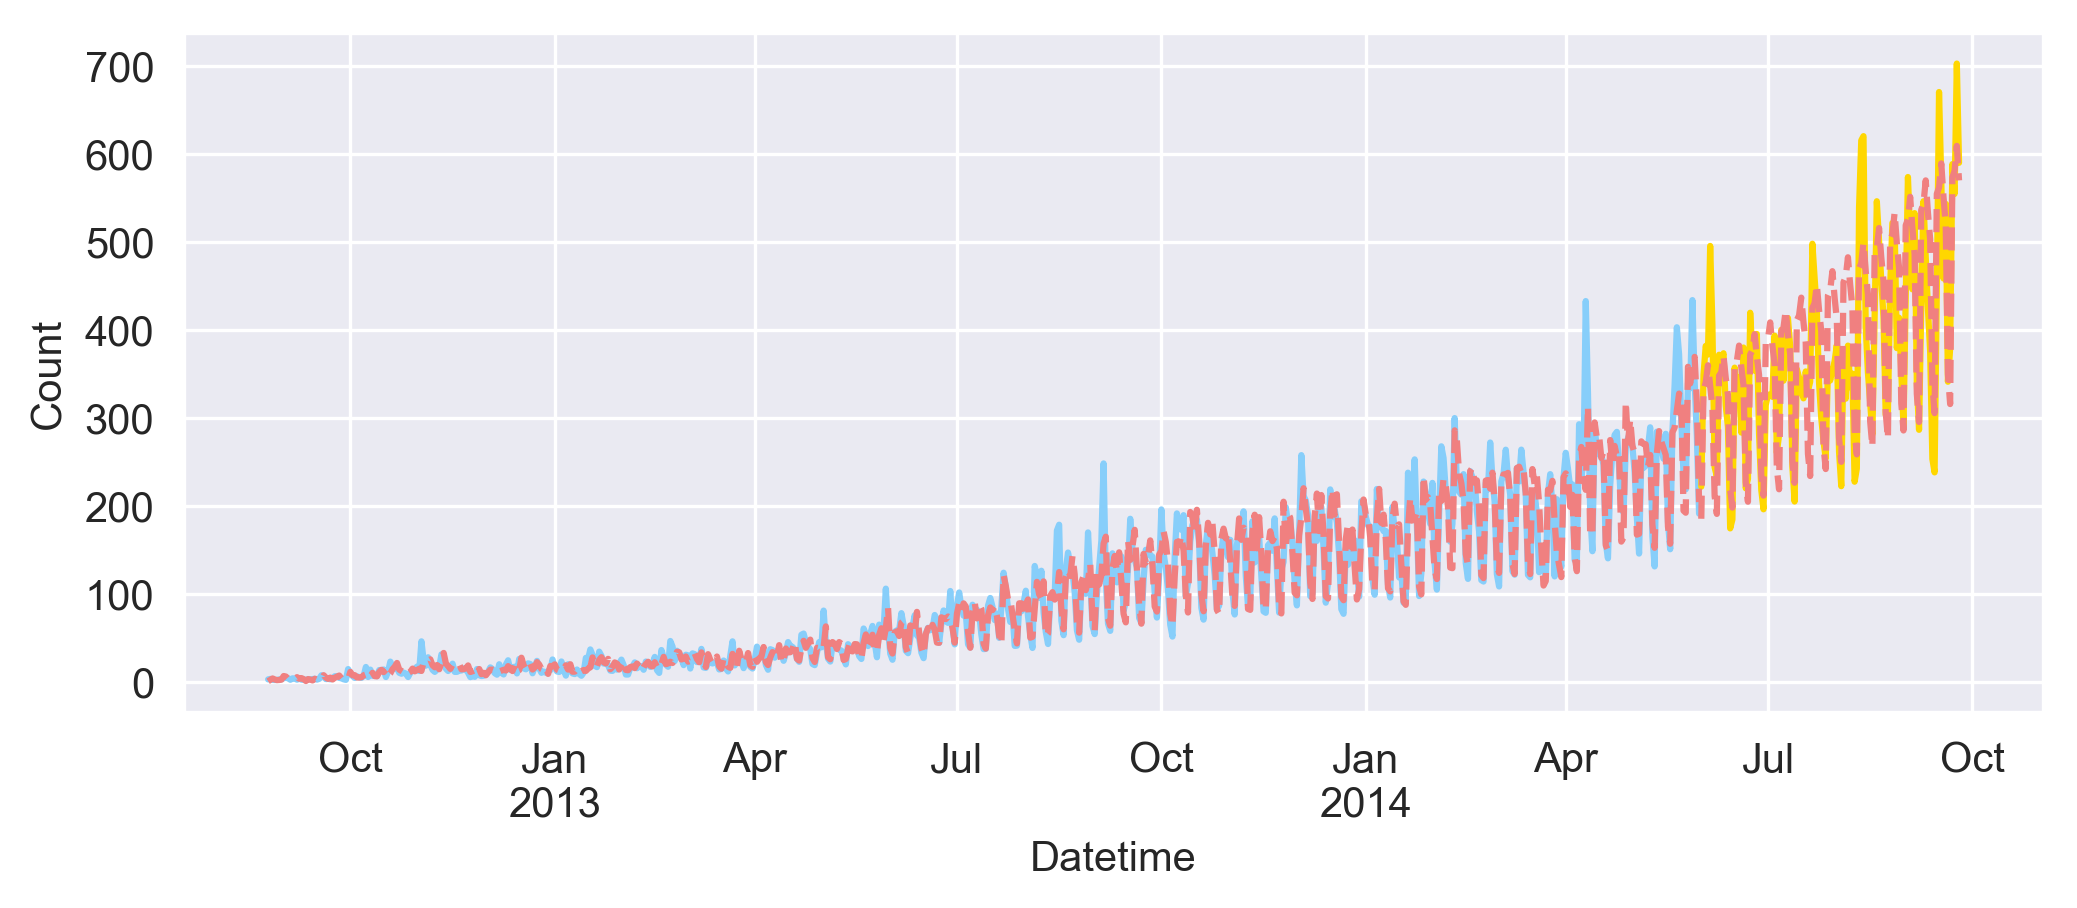

In [38]:
arima = sm.tsa.statespace.SARIMAX(train_log, order = (4, 1, 4), seasonal_order=(1, 1, 1, 7),
                            enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

arima_results = arima.forecast(len(test))

train['Count'].plot(label='training', color = 'lightskyblue')
test['Count'].plot(label='test', color = 'gold')
np.exp(arima.fittedvalues).plot(ls = '--', color = 'lightcoral', 
                              label = 'Triple Exp Add-Mul')
np.exp(arima_results).plot(ls = '--', color = 'lightcoral')
plt.ylabel('Count');

In [39]:
RMSE['arima'] = np.sqrt(mean_squared_error(test['Count'], np.exp(arima_results)))
print(RMSE['arima'])

63.3086905508608


Summary of all models tested

In [40]:
pd.Series(RMSE).sort_values()

tes_add_add     59.676840
tes_add_mul     61.941503
arima           63.308691
des_mul         94.378964
des_add        124.049490
MA             163.720137
EWMA           172.196885
ses            173.780672
simple         299.698115
dtype: float64